# Predicción de Tratamientos químicos de Integridad & Corrosión para pozos 

Importación de los modulos a utilizar en este cuaderno. Tener en cuenta que los paquetes deben estar previamente instalados en el global/virtual environment.

In [232]:
import numpy as np 
import pandas as pd
import matplotlib as plot
import seaborn as sns
import os
import sklearn
from sklearn.preprocessing import MinMaxScaler

Lectura del archivo excel que contiene los datos de recomendaciones. 

In [233]:
df=pd.read_excel(os.path.join('Data', 'BD Autom Recomendaciones.xlsx'))
df.head()

,Número de protocolo,Responsable,Operadora,Pozo,Batería,Yacimiento,Base,Fecha de emisión,SLA,Prod Bruta,...,Costo [U$S/mes] TQ Propuesto 2,PQ Propuesto 3,Modalidad PQ Propuesto 3,Punto Inyección PQ Propuesto 3,Tasa Inyección (l/d) PQ Propuesto 3,Volumen Batch PQ Propuesto 3 (l),Frecuencia batcheo PQ Propuesto 3,Concentración [ppmV] PQ Propuesto 3,Precio del PQ [U$S/l] Propuesto 3,Costo [U$S/mes] TQ Propuesto 3
0,0,Ingeniero 1,Operadora 1 Santa Cruz,0,0,El Chola,Las Heras,2020-02-27,BES,60.0,...,324.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Ingeniero 2,Operadora 1 Chubut,1,1,El Trébol,Comodoro Rivadavia,2020-10-27,AIB,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Ingeniero 2,Operadora 1 Chubut,2,2,El Trébol,Comodoro Rivadavia,2020-10-27,BES,222.0,...,670.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Ingeniero 2,Operadora 1 Chubut,3,3,El Trébol,Comodoro Rivadavia,2020-10-28,AIB,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Ingeniero 2,Operadora 1 Chubut,4,4,El Trébol,Comodoro Rivadavia,2020-10-28,AIB,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [234]:
for col in df.columns:
    print(col)

Número de protocolo
Responsable
Operadora
Pozo
Batería
Yacimiento
Base
Fecha de emisión
SLA
Prod Bruta
Prod Neta
Corte de agua (%)
Fecha Control
Objetivo Recomendación
SD
OT
CIP
Corrosión según Fe+2
Corr según CO2 (aq)
Corr según CO2 (g)
Corr según H2S (g)
BSRp
PQ Anterior 1
Modalidad PQ Anterior 1
Punto Inyección PQ Anterior 1
Tasa Inyección (l/d)  PQ Anterior 1 
Volumen Batch PQ Anterior 1 (l)
Frecuencia batcheo PQ Anterior 1
Concentración [ppmV] PQ Anterior 1
Precio del PQ [U$S/l] Anterior 1
Costo [U$S/mes] TQ Anterior 1
PQ Anterior 2
Modalidad PQ Anterior 2
Punto Inyección PQ Anterior 2
Tasa Inyección (l/d)  PQ Anterior 2 
Volumen Batch PQ Anterior 2 (l)
Frecuencia batcheo PQ Anterior 2
Concentración [ppmV] PQ Anterior 2
Precio del PQ [U$S/l] Anterior 2
Costo [U$S/mes] TQ Anterior 2
PQ Propuesto 1
Modalidad PQ Propuesto 1
Punto Inyección PQ Propuesto 1
Tasa Inyección (l/d)  PQ Propuesto 1 
Volumen Batch PQ Propuesto 1 (l)
Frecuencia batcheo PQ Propuesto 1
Concentración [ppmV] PQ Pr

Filtrado de la base de datos para ver sólo los datos a utilizar. Para entrenar esta Neural Network, se utilizarán solamente las recomendaciones emitidas para la "Operadora 1" de la provincia de Chubut.

In [235]:
df= df.loc[df["Operadora"]=="Operadora 1 Chubut"]
df=df.reset_index()

### Las variables de entrada para la Neural Network serían las siguientes 11:

    SD, OT, CIP, Corr Fe+2, Corr CO2 (aq), Corr H2S (g), Corr CO2 (g), BSRp, Prod Bruta, Prod Neta y SLA

#### Definición de las variables de entrada cualitativas en términos binarios

Se elige definir como 1 cuando el SLA es BES y 0 cuando es AIB o PCP

In [236]:
for i in range(len(df['Número de protocolo'])):
    if 'BES' in str(df['SLA'][i]):
        df['SLA'][i]=1
    else:
        df['SLA'][i]=0

var_cual=df['SLA']
var_cual

<ipython-input-236-67566288c990>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SLA'][i]=0
<ipython-input-236-67566288c990>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SLA'][i]=1


0      0
1      1
2      0
3      0
4      1
      ..
172    0
173    0
174    0
175    1
176    1
Name: SLA, Length: 177, dtype: object

#### Normalizar a la media variables de entrada cuantitativas

La normalización utilizada en el presente proyecto está dada por:

        X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

        X_scaled = X_std * (max - min) + min

        where min, max = feature_range.

In [237]:
var_cuant=df[['SD','OT','CIP', 'Prod Bruta', 'Prod Neta','Corr según H2S (g)','BSRp','Corrosión según Fe+2','Corr según CO2 (aq)','Corr según CO2 (g)']]

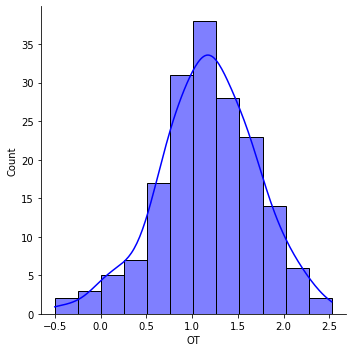

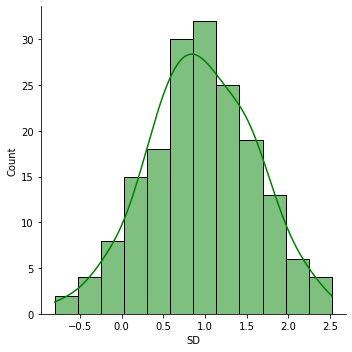

In [238]:
sns.displot(df['OT'], kind='hist', kde=True, bins=int(6/0.5), color = 'blue')
sns.displot(df['SD'], kind='hist', kde=True, bins=int(6/0.5), color = 'green')

In [239]:
scaler=MinMaxScaler()

In [240]:
var_cuant[['SD','OT','CIP', 'Prod Bruta', 'Prod Neta','Corr según H2S (g)','BSRp','Corrosión según Fe+2','Corr según CO2 (aq)','Corr según CO2 (g)']]=scaler.fit_transform(var_cuant)

var_cuant.head()

<ipython-input-240-75ff125adf0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_cuant[['SD','OT','CIP', 'Prod Bruta', 'Prod Neta','Corr según H2S (g)','BSRp','Corrosión según Fe+2','Corr según CO2 (aq)','Corr según CO2 (g)']]=scaler.fit_transform(var_cuant)
C:\Users\gfernandez\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\gfernandez\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:69

,SD,OT,CIP,Prod Bruta,Prod Neta,Corr según H2S (g),BSRp,Corrosión según Fe+2,Corr según CO2 (aq),Corr según CO2 (g)
0,0.572327,0.594919,0.582524,0.079096,0.005365,0.141212,0.000,0.027395,0.194619,0.003883
1,0.632571,0.561868,0.629355,0.621469,0.039624,0.070606,0.625,0.250158,0.809709,0.004854
2,0.632571,0.694072,0.629355,0.059322,0.013046,0.000000,0.125,0.134812,NaN,0.029773
3,0.210857,0.231357,0.384923,0.070621,0.012192,0.000000,0.250,0.340994,0.080184,0.003560
4,0.930673,0.916474,0.480552,0.522599,0.022860,0.315261,NaN,0.058022,0.187280,0.028907


#### Unir variables cualitativas con cuantitativas en dataframe de variables de entrada

In [241]:
var_input=var_cuant.join(var_cual)
var_input.head()

,SD,OT,CIP,Prod Bruta,Prod Neta,Corr según H2S (g),BSRp,Corrosión según Fe+2,Corr según CO2 (aq),Corr según CO2 (g),SLA
0,0.572327,0.594919,0.582524,0.079096,0.005365,0.141212,0.000,0.027395,0.194619,0.003883,0
1,0.632571,0.561868,0.629355,0.621469,0.039624,0.070606,0.625,0.250158,0.809709,0.004854,1
2,0.632571,0.694072,0.629355,0.059322,0.013046,0.000000,0.125,0.134812,NaN,0.029773,0
3,0.210857,0.231357,0.384923,0.070621,0.012192,0.000000,0.250,0.340994,0.080184,0.003560,0
4,0.930673,0.916474,0.480552,0.522599,0.022860,0.315261,NaN,0.058022,0.187280,0.028907,1
